In [203]:
# Code from https://github.com/Blealtan/efficient-kan/blob/master/src/efficient_kan/kan.py 
import torch
import torch.nn.functional as F
import math
import pandas as pd
from tqdm import tqdm
import seaborn as sns


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        #print(f"x shape: {x.shape}, bases shape: {bases.shape}")
        #print(f"Grid: {grid}")
        #print(f"Bases at k=0: {bases}")
        for k in range(1, self.spline_order + 1):
            bases_old = bases
            # This adds the new terms
            bases = (
                (
                    (x - grid[:, : -(k + 1)]) 
                    # [x_i - t_{-K}]
                    # [x_i - t_{-K+1}]
                    # ...
                    # [x_i - t_{G+K}]
                    / (grid[:, k:-1] - grid[:, : -(k + 1)])  # k * delta
                    * bases[:, :, :-1]  # 1 for the region we are in
                )
                # Total:
                # [0,
                # ...
                # x_i - t_j,
                # 0, 
                # ...,
                # ]
            +
            # This should be left shifting
                (
                    (grid[:, k + 1 :] - x)
                    / (grid[:, k + 1 :] - grid[:, 1:(-k)])  # k * delta
                    * bases[:, :, 1:]
                )
            )
            # print(f"x-grid difference at {k=}: {(x - grid[:, : -(k + 1)])}")# * bases_old[:, :, :-1]}")
            # print(f"grid-x difference at {k=}: {(grid[:, k + 1 :] - x)}")# *  bases_old[:, :, 1:]}")
            # print(f"Bases at {k=}: {bases}")


        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
        enable_layer_norm=True,
        layer_norm_eps=1e-5,
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.enable_layer_norm = enable_layer_norm
        self.layer_norm_eps = layer_norm_eps

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        result = [x.var().item()]
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
            # print(x.shape)
            if self.enable_layer_norm:
                x = (x - x.mean(-1, keepdim=True)) / torch.sqrt(
                    self.layer_norm_eps + x.var(-1, keepdim=True, unbiased=False)
                )
            result.append(x.var(axis=-1).mean().item())
            # x = (x - x.mean()) / (x.std() + 1e-5)
        return x, result

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [204]:
torch.manual_seed(12)
kan = KAN(
    [1] + [20 for _ in range(50)],
    grid_range=[-5, 5],
    grid_size=30,
    enable_layer_norm=False,
)
kan_norm = KAN(
    [1] + [20 for _ in range(50)],
    grid_range=[-5, 5],
    grid_size=30,
    enable_layer_norm=True,
)

In [205]:
from matplotlib import pyplot as plt
data = []
data_norm = []
num_experiments = 100
for i in tqdm(range(num_experiments)):
    nums = torch.randn(1000, 1) #* 1000
    data.append(kan(nums)[1])
    data_norm.append(kan_norm(nums)[1])
    for layer in kan.layers:
        layer.reset_parameters()
    for layer in kan_norm.layers:
        layer.reset_parameters()
# plt.plot(kan(nums)[1])
df = pd.DataFrame(data)
dfnorm = pd.DataFrame(data_norm)

100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


In [209]:

sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc=None)

In [227]:

dfx = df.assign(architecture=lambda _: 'vanilla KAN').set_index('architecture')
dfxnorm = dfnorm.assign(architecture=lambda _: 'KAN+LN').set_index('architecture')
dfz=pd.concat([dfx, dfxnorm]).T

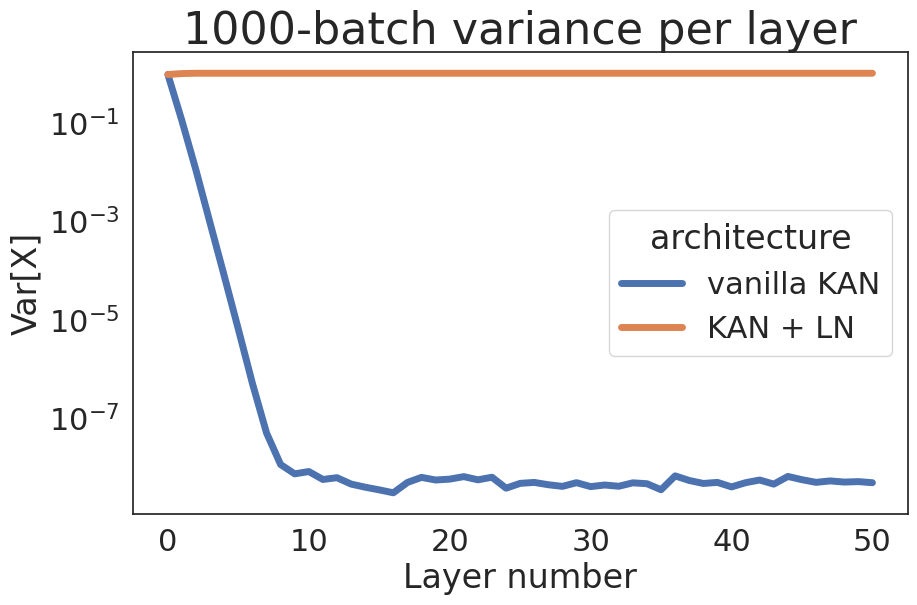

In [229]:

plt.figure(figsize=(10, 6))

plt.yscale('log')
# ax=sns.lineplot(dfx.T, errorbar='sd')
# sns.lineplot(dfxnorm.T, errorbar='sd', color='orange',ax=ax)
ax=sns.lineplot(dfz, errorbar='sd', linewidth = 5)
for line in ax.lines:
    line.set_linestyle("-")

ax.legend(
    ax.lines,
    [
        "vanilla KAN",
        "KAN + LN",
    ],
    title="architecture",
)




plt.title('1000-batch variance per layer', fontsize=32)
plt.ylabel('Var[X]')
plt.xlabel('Layer number')

plt.savefig('kan_gradients.png', bbox_inches='tight', dpi=300)


In [148]:
xi = 0.33
tj = 0.2
tjp = 0.6
delta = tjp - tj

kan(torch.FloatTensor([xi])[None, :])

(tensor([[0.0043]], grad_fn=<AddBackward0>),
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan])

In [149]:
(tjp - xi) / delta

0.6749999999999999

In [150]:
Q = (xi - tj) * (tjp - xi + delta) / (2 * delta ** 2) + (tjp - xi) * (xi - tj + delta) / (2 * delta ** 2)

[
    round((tjp - xi) ** 3 / (6 * delta ** 3), 4),
    # Expect: 0.5244
    round((tjp - xi) ** 2 * (xi - tj + 2 * delta) / (6 * delta ** 3) + Q * (tjp - xi + delta) / (3 *delta), 4),
    round((xi - tj) ** 2 * (tjp - xi + 2 * delta) / (6 * delta ** 3) + Q * (xi - tj + delta) / (3 * delta), 4),
    round((xi - tj) ** 3 / (6 * delta ** 3), 4)
]

[0.0513, 0.5782, 0.3648, 0.0057]